In [ ]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

from tqdm.notebook import tqdm

In [2]:
notes = pd.read_csv("../data/notes_with_topics.tsv", sep="\t")

In [4]:
ratings = pd.read_csv("../data/ratings-00010.tsv", sep="\t")

In [5]:
df = ratings.merge(
    notes,
    on="noteId",
    how="inner"
)

In [6]:
df.shape

(173, 62)

In [7]:
TOPK = 10


post_counts = notes["topic"].value_counts(dropna=False)
top_topics = post_counts.head(TOPK).index.tolist()

posts_topic_plot = notes["topic"].where(notes["topic"].isin(top_topics), "Other Topics")
posts_frac = posts_topic_plot.value_counts(normalize=True).sort_values(ascending=False) * 100

ratings_topic_plot = df["topic"].where(df["topic"].isin(top_topics), "Other Topics")
ratings_frac = ratings_topic_plot.value_counts(normalize=True).reindex(posts_frac.index, fill_value=0) * 100



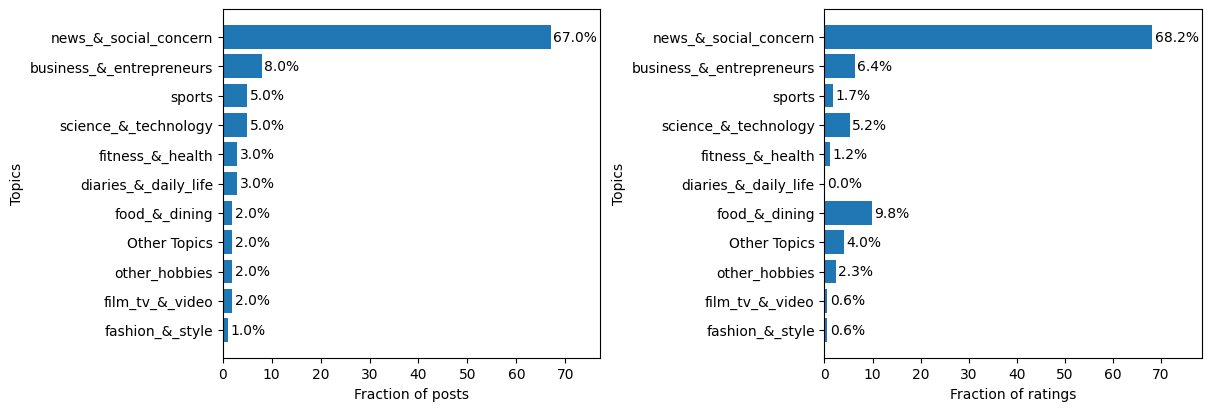

In [8]:


def _barh_with_pct(ax, series_pct, xlabel):
    ax.barh(series_pct.index, series_pct.values)
    ax.invert_yaxis()
    ax.set_xlabel(xlabel)
    ax.set_ylabel("Topics")

    for y, v in enumerate(series_pct.values):
        ax.text(v + 0.5, y, f"{v:.1f}%", va="center")

    ax.set_xlim(0, max(10, series_pct.max() * 1.15))

fig, axes = plt.subplots(1, 2, figsize=(12, 4), constrained_layout=True)

_barh_with_pct(axes[0], posts_frac, "Fraction of posts")
_barh_with_pct(axes[1], ratings_frac, "Fraction of ratings")

plt.show()


In [9]:
status_map = {
    "HELPFUL": "HELPFUL",
    "NOT_HELPFUL": "NOT HELPFUL",
    "SOMEWHAT_HELPFUL": "NEEDS MORE RATINGS"
}

df["note_status"] = df["helpfulnessLevel"].map(status_map)


In [10]:
df["note_status"].value_counts()


note_status
HELPFUL               106
NOT HELPFUL            63
NEEDS MORE RATINGS      4
Name: count, dtype: int64

In [11]:
top_topics = (
    df["topic"]
    .value_counts()
    .head(10)
    .index
    .tolist()
)

df_s11 = df[df["topic"].isin(top_topics)].copy()


In [12]:
STATUS_ORDER = ["HELPFUL", "NOT HELPFUL", "NEEDS MORE RATINGS"]

ct = (
    df_s11
    .groupby(["topic", "note_status"])
    .size()
    .unstack(fill_value=0)
)

for s in STATUS_ORDER:
    if s not in ct.columns:
        ct[s] = 0
ct = ct[STATUS_ORDER]

ct_pct = ct.div(ct.sum(axis=1), axis=0) * 100

ct_pct = ct_pct.sort_values("HELPFUL", ascending=False)

ct_pct.head()


note_status,HELPFUL,NOT HELPFUL,NEEDS MORE RATINGS
topic,,,
fashion_&_style,100.000000,0.000000,0.000000
fitness_&_health,100.000000,0.000000,0.000000
sports,100.000000,0.000000,0.000000
science_&_technology,77.777778,22.222222,0.000000
business_&_entrepreneurs,72.727273,18.181818,9.090909


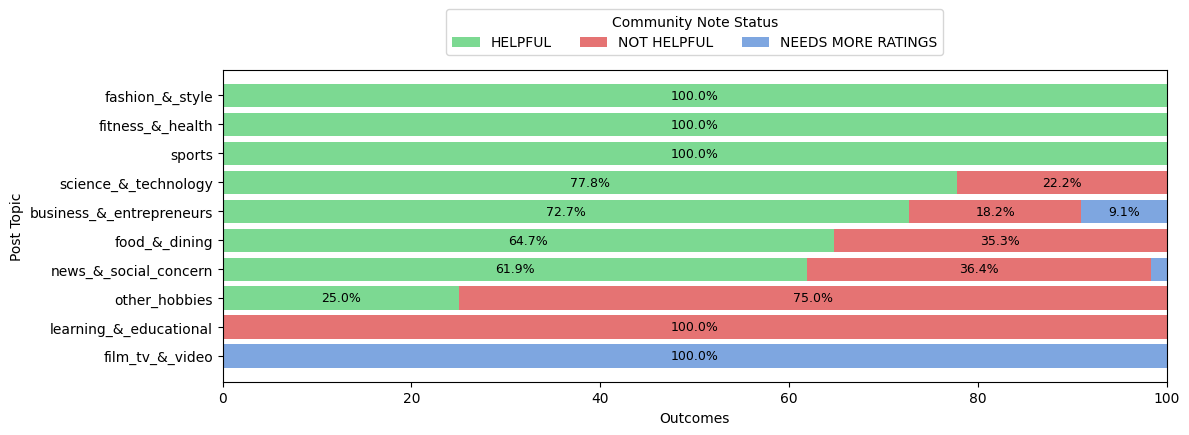

In [13]:
fig, ax = plt.subplots(figsize=(12, 4.5))

y = np.arange(len(ct_pct.index))
left = np.zeros(len(ct_pct.index))

colors = {
    "HELPFUL": "#7cd992",
    "NOT HELPFUL": "#e57373",
    "NEEDS MORE RATINGS": "#7ea6e0",
}

for status in STATUS_ORDER:
    vals = ct_pct[status].values
    ax.barh(y, vals, left=left, label=status, color=colors[status])

    for i, (l, v) in enumerate(zip(left, vals)):
        if v >= 3:
            ax.text(l + v / 2, i, f"{v:.1f}%", ha="center", va="center", fontsize=9)

    left += vals

ax.set_yticks(y)
ax.set_yticklabels(ct_pct.index)
ax.invert_yaxis()
ax.set_xlim(0, 100)
ax.set_xlabel("Outcomes")
ax.set_ylabel("Post Topic")
ax.legend(
    title="Community Note Status",
    ncols=3,
    bbox_to_anchor=(0.5, 1.12),
    loc="center"
)

plt.tight_layout()
plt.show()


In [14]:
df.head()

,noteId,raterParticipantId,createdAtMillis_x,version,agree,disagree,helpful,notHelpful,helpfulnessLevel,helpfulOther,...,summary,isMediaNote,isCollaborativeNote,lang,summary_en,topic,topic_confidence,political_subcategory,political_subcat_conf,note_status
0,1992693777765724201,D52155545C7962999B0C746AA4984BC00F8FD1043D1B5E...,1763968760089,2,0,0,0,0,HELPFUL,0,...,This user recently posted video proving their ...,0,0,en,This user recently posted video proving their ...,news_&_social_concern,0.916759,413 - Nationalisation,0.028654,HELPFUL
1,1894487326044426347,5351640476C0E07E2327B0A8E69126BD75CC70401B60EB...,1740622391333,2,0,0,0,0,NOT_HELPFUL,0,...,Trump is a cockwomble. Www.trumpisacockwomble...,0,0,en,Trump is a cockwomble. Www.trumpisacockwomble...,news_&_social_concern,0.987794,413 - Nationalisation,0.033538,NOT HELPFUL
2,1686958637409820672,A10A79C69170B084D1AEF4A26E47CBF585F2BECD1496F9...,1691086268111,2,0,0,0,0,HELPFUL,0,...,It should be noted that filet mignon is usuall...,0,0,en,It should be noted that filet mignon is usuall...,food_&_dining,0.943273,NaN,NaN,HELPFUL
3,1714493221450006906,DC3B106046BA7B5B31EA1A82C5884A74E1B85CD259B46D...,1697658569676,2,0,0,0,0,NOT_HELPFUL,0,...,Es una cuenta satírica. Obviamente persigue co...,0,0,es,It is a satirical account. obviously pursues f...,news_&_social_concern,0.952118,102 - Foreign Special Relationships: Negative,0.032280,NOT HELPFUL
4,1975264849954545713,117390030411918BE8880408ED62E43E9876AA3FBADD81...,1759812206515,2,0,0,0,0,HELPFUL,0,...,NNN: Opinion and rhetoric,0,0,en,NNN: Opinion and rhetoric,news_&_social_concern,0.963025,413 - Nationalisation,0.033223,HELPFUL


In [ ]:
df.columns

Index(['noteId', 'raterParticipantId', 'createdAtMillis_x', 'version', 'agree',
       'disagree', 'helpful', 'notHelpful', 'helpfulnessLevel', 'helpfulOther',
       'helpfulInformative', 'helpfulClear', 'helpfulEmpathetic',
       'helpfulGoodSources', 'helpfulUniqueContext', 'helpfulAddressesClaim',
       'helpfulImportantContext', 'helpfulUnbiasedLanguage', 'notHelpfulOther',
       'notHelpfulIncorrect', 'notHelpfulSourcesMissingOrUnreliable',
       'notHelpfulOpinionSpeculationOrBias', 'notHelpfulMissingKeyPoints',
       'notHelpfulOutdated', 'notHelpfulHardToUnderstand',
       'notHelpfulArgumentativeOrBiased', 'notHelpfulOffTopic',
       'notHelpfulSpamHarassmentOrAbuse', 'notHelpfulIrrelevantSources',
       'notHelpfulOpinionSpeculation', 'notHelpfulNoteNotNeeded',
       'ratedOnTweetId', 'ratingSourceBucketed', 'noteAuthorParticipantId',
       'createdAtMillis_y', 'tweetId', 'classification', 'believable',
       'harmful', 'validationDifficulty', 'misleadingOther',
 

In [15]:
factor = pd.read_csv(
    "/Users/guojiawei/UW/INFO/INFO494/info-470-project-2/Week6/prescoringNoteModelOutput_5dim.tsv", sep="\t"
)

In [16]:
df = df.merge(factor, on="noteId", how="inner")


In [17]:
df.shape

(104, 75)

In [18]:
df.head()

,noteId,raterParticipantId,createdAtMillis_x,version,agree,disagree,helpful,notHelpful,helpfulnessLevel,helpfulOther,...,internalNoteFactor2,internalNoteFactor3,internalNoteFactor4,internalNoteFactor5,scorerName,lowDiligenceNoteIntercept,lowDiligenceNoteFactor1,lowDiligenceNoteInterceptRound2,harassmentNoteIntercept,harassmentNoteFactor1
0,1686958637409820672,A10A79C69170B084D1AEF4A26E47CBF585F2BECD1496F9...,1691086268111,2,0,0,0,0,HELPFUL,0,...,-0.300820,-0.851778,-0.025206,-0.722385,MFCoreScorer,0.808952,0.145025,1.538856,-0.071221,-0.233691
1,1714493221450006906,DC3B106046BA7B5B31EA1A82C5884A74E1B85CD259B46D...,1697658569676,2,0,0,0,0,NOT_HELPFUL,0,...,-0.265935,-0.261665,0.472307,0.136262,MFCoreScorer,0.052483,-2.119263,1.664907,NaN,NaN
2,1754570053960306948,669375E7922151599E0A84EC154EF0E7BBEB0B76948347...,1707164471044,2,0,0,0,0,HELPFUL,0,...,-0.633226,-0.558807,-0.167951,-0.314702,MFCoreScorer,-1.630584,0.040396,-3.304023,-0.068941,0.789398
3,1686958637409820672,52F41180D9D61743F162C5EF58B389C080D79AF74FEFD9...,1691100651343,2,0,0,0,0,HELPFUL,0,...,-0.300820,-0.851778,-0.025206,-0.722385,MFCoreScorer,0.808952,0.145025,1.538856,-0.071221,-0.233691
4,1686958637409820672,9025555347570ED3D4C545383A77B787333A3788AA4DB4...,1691071570778,2,0,0,0,0,HELPFUL,0,...,-0.300820,-0.851778,-0.025206,-0.722385,MFCoreScorer,0.808952,0.145025,1.538856,-0.071221,-0.233691


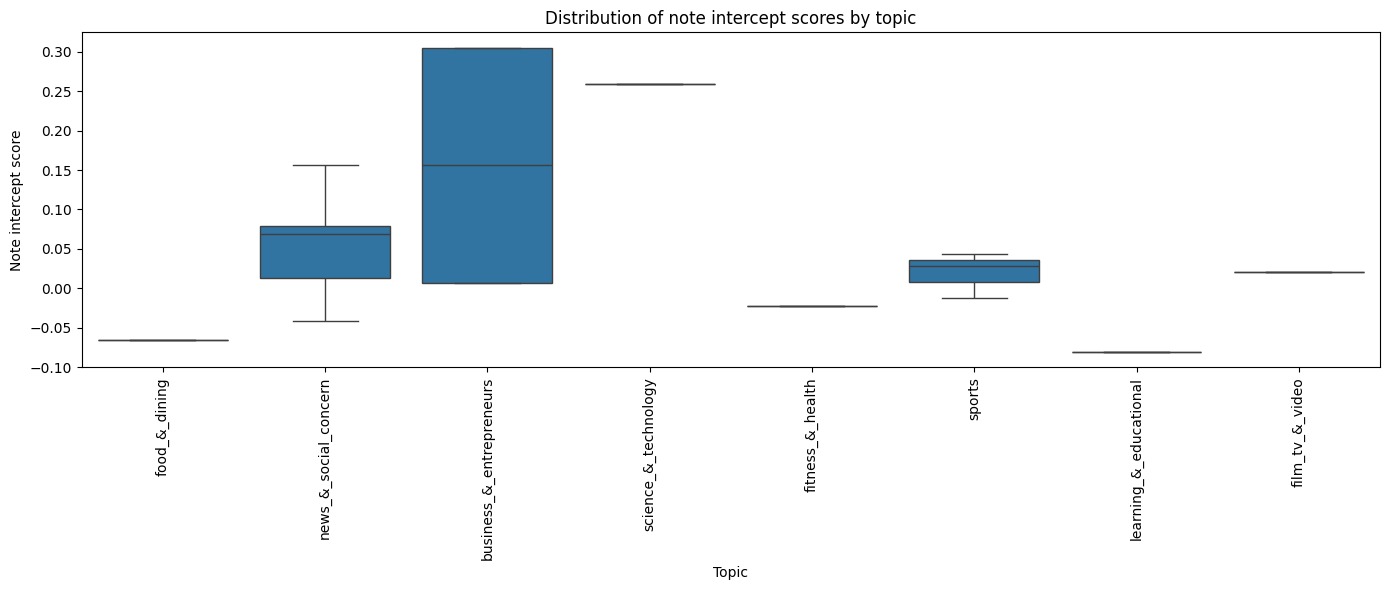

In [19]:
plot_df = df.dropna(subset=["topic", "internalNoteIntercept"])

plt.figure(figsize=(14, 6))
sns.boxplot(data=plot_df, x="topic", y="internalNoteIntercept", showfliers=False)

plt.xticks(rotation=90)
plt.xlabel("Topic")
plt.ylabel("Note intercept score")
plt.title("Distribution of note intercept scores by topic")
plt.tight_layout()
plt.show()


go file by file, each file get 10% of ratings


Have a flag to take subset or full sample